# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler

Загружаем датасеты

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def info_func(df):
    print('Общая информация')
    print('')
    print(df.info())
    print('')
    print(df.describe())
    print('')
    print('Кол-во строк дубликатов')
    print('')
    print(df[df.duplicated()].count())
    print('')
    print('Кол-во пропущенных значений')
    print('')
    print(df.isna().sum())        

In [4]:
info_func(df_0)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.

In [5]:
info_func(df_1)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.

In [6]:
info_func(df_2)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.

Посмотрим на распределение признаков

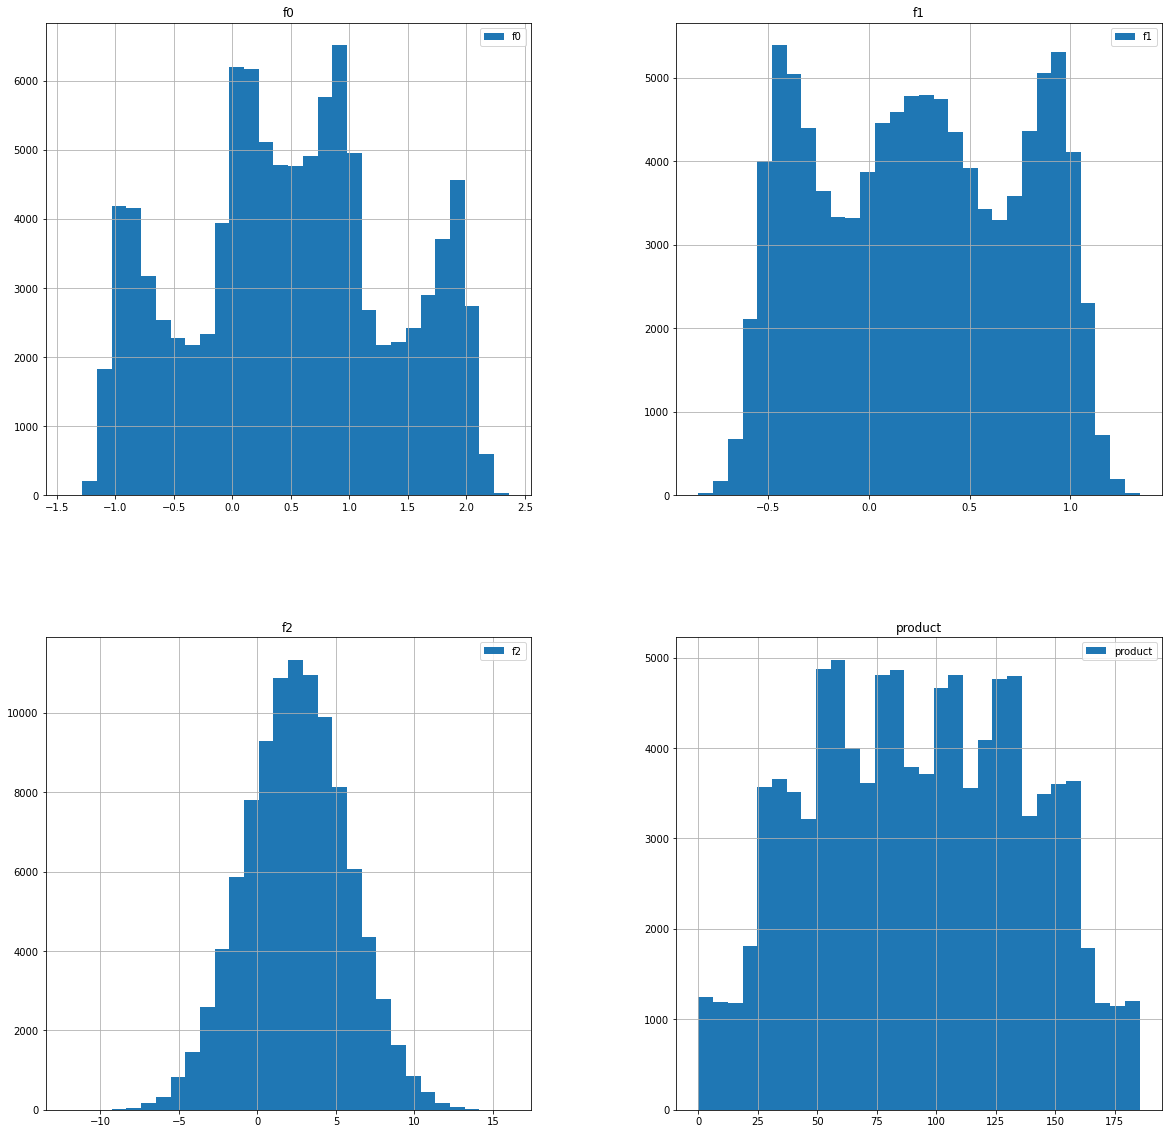

In [7]:
df_0.hist(bins=30, figsize=(20,20), legend = True)
plt.show()

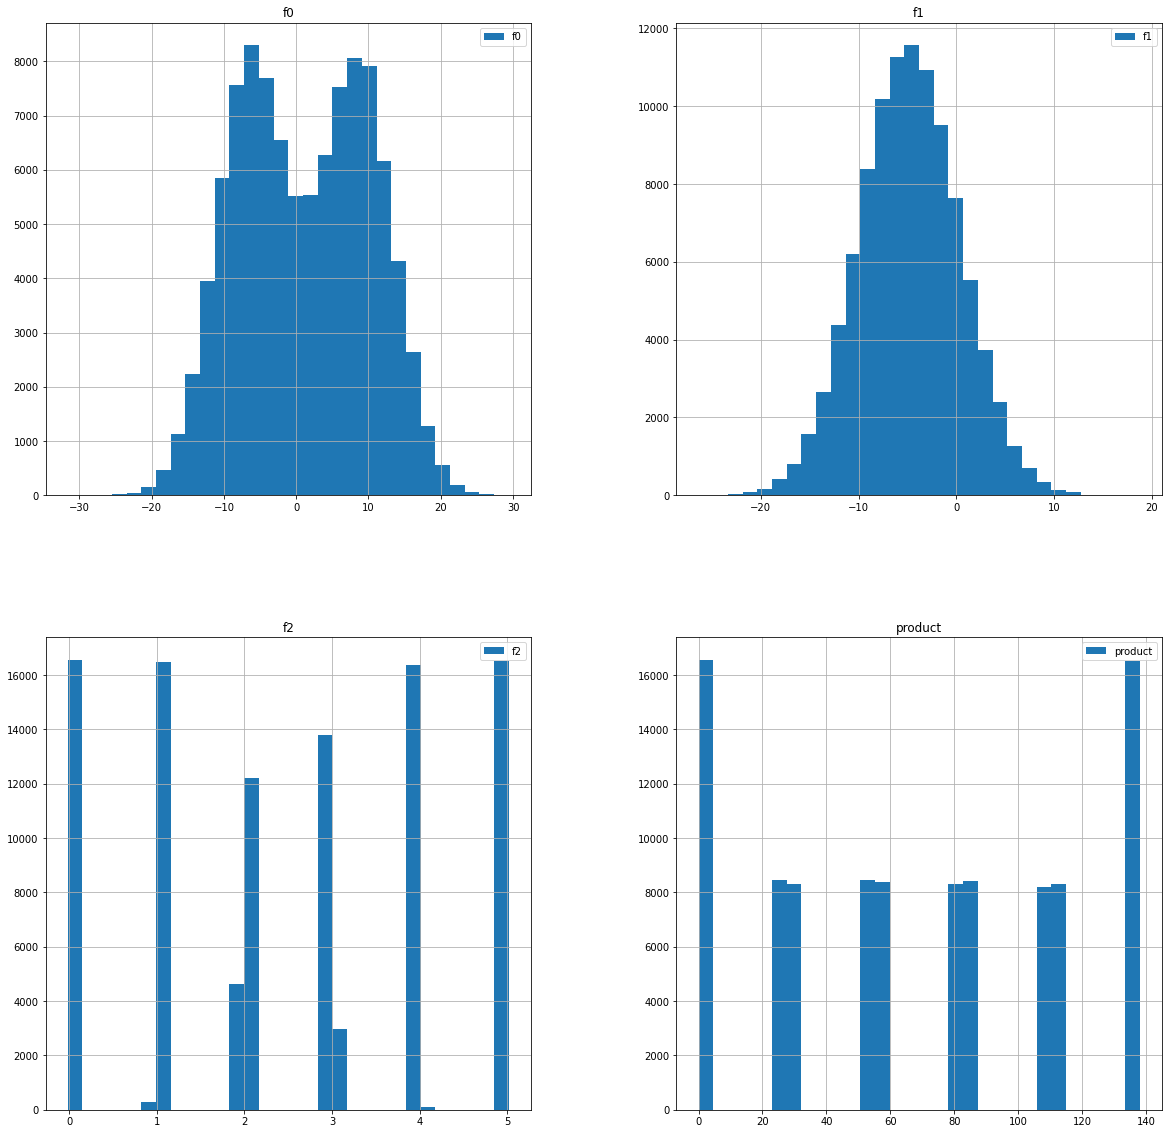

In [8]:
df_1.hist(bins=30, figsize=(20,20), legend = True)
plt.show()

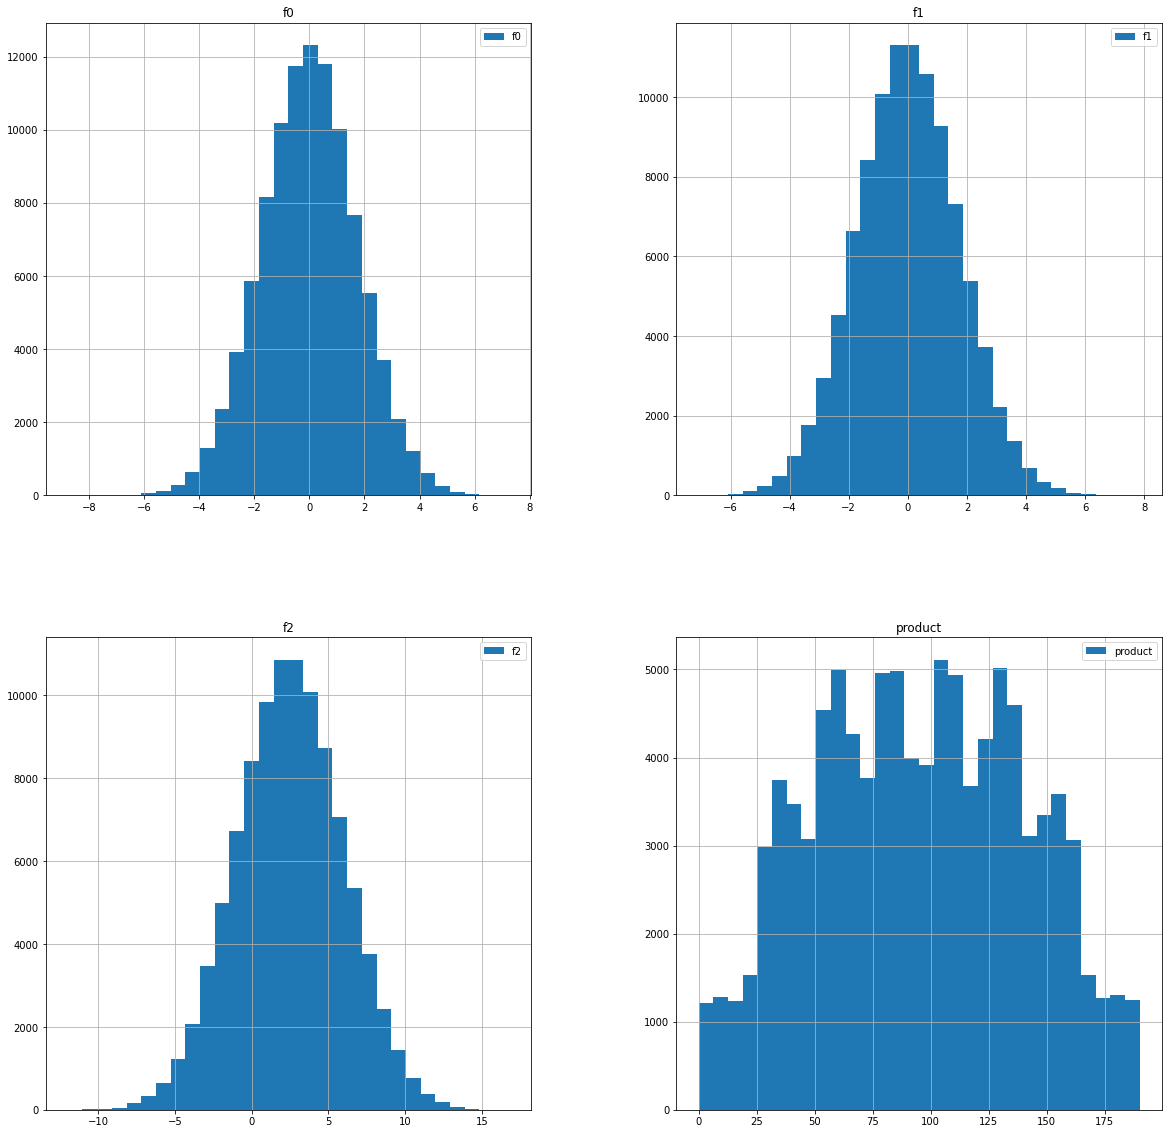

In [9]:
df_2.hist(bins=30, figsize=(20,20), legend = True)
plt.show()

Удаляем столбец id за ненадобностью

In [10]:
df_0 = df_0.drop(columns=['id'], axis=0)
df_1 = df_1.drop(columns=['id'], axis=0)
df_2 = df_2.drop(columns=['id'], axis=0)

### Вывод
- Данные загружены. 
- Дубликатов нет. 
- Столбец id удален за ненадобность.
- Были рассмотрены распределения признаков. Распределение нормальное.

## Обучение и проверка модели

Введем глобальные переменные

In [11]:
RD_ST = 12345
STATE = np.random.RandomState(12345)

Сделаем функцию, чтобы поделить на обучающую и валидационную выборки и нормализировать

In [12]:
def split_norm_func(df):
    train, valid = train_test_split(df, test_size=0.25, random_state=RD_ST)
    features_train = train.drop(columns=['product'], axis=0).reset_index(drop=True)
    target_train = train['product'].reset_index(drop=True)
    features_valid = valid.drop(columns=['product'], axis=0).reset_index(drop=True)
    target_valid= valid['product'].reset_index(drop=True)
    print('Кол-во строк в обучающей:', train.shape[0])
    print('Кол-во строк в валидации:', valid.shape[0])
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    return features_train, target_train, features_valid, target_valid

In [13]:
features_train_0, target_train_0, features_valid_0, target_valid_0 = split_norm_func(df_0)

Кол-во строк в обучающей: 75000
Кол-во строк в валидации: 25000


In [14]:
features_train_1, target_train_1, features_valid_1, target_valid_1 = split_norm_func(df_1)

Кол-во строк в обучающей: 75000
Кол-во строк в валидации: 25000


In [15]:
features_train_2, target_train_2, features_valid_2, target_valid_2 = split_norm_func(df_2)

Кол-во строк в обучающей: 75000
Кол-во строк в валидации: 25000


Заглушка на предупреждения, которые просто мешают читать

In [16]:
simplefilter(action='ignore', category=FutureWarning)

Обучаем модели (на RandomForestRegressor, дело в том, что я уже потом увидел условие про то, что надо модель на линейной регрессии, но удалять было жалко - так что можно будет просто потом сравнить)

In [17]:
def model_fit_func(features_train,target_train,features_valid,target_valid):
    best_model = None
    best_result = 10000
    best_est = 0
    best_depth = 0
    for est in range(10, 51, 10):
        for depth in range (1, 11):
            model = RandomForestRegressor(random_state=RD_ST, n_estimators=est, max_depth=depth)
            model.fit(features_train,target_train) 
            predictions_valid = model.predict(features_valid) 
            result = mean_squared_error(target_valid, predictions_valid)**0.5
            if result < best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth

    print("RMSE наилучшей модели на валидационной выборке:", best_result,  "Количество деревьев:", best_est, "Максимальная глубина:", depth)
    predict_mean = predictions_valid.mean()
    print('')
    print('Среднее среди предсказанного запаса:', predict_mean)

In [18]:
print('Регион 0')
print('')
#model_fit_func(features_train_0,target_train_0,features_valid_0,target_valid_0)

Регион 0



In [19]:
print('Регион 1')
print('')
#model_fit_func(features_train_1,target_train_1,features_valid_1,target_valid_1)

Регион 1



In [20]:
print('Регион 2')
print('')
#model_fit_func(features_train_2,target_train_2,features_valid_2,target_valid_2)

Регион 2



Тестируем модели

In [21]:
def model_test_func(features_train,target_train,features_test,target_test,est,depth):
    model = RandomForestRegressor(random_state=RD_ST, n_estimators=est, max_depth=depth)
    model.fit(features_train,target_train) 
    predictions_test = model.predict(features_test) 
    result = mean_squared_error(target_test, predictions_test)**0.5
    predict_mean = predictions_test.mean()
    print("RMSE наилучшей модели на тестовой выборке:", result)
    print('')
    print('Среднее среди предсказанного запаса:', predict_mean)

In [22]:
print('Регион 0')
print('')
#model_test_func(features_train_0,target_train_0,features_test_0,target_test_0,40,10)

Регион 0



In [23]:
print('Регион 1')
print('')
#model_test_func(features_train_1,target_train_1,features_test_1,target_test_1,10,10)

Регион 1



In [24]:
print('Регион 2')
print('')
#model_test_func(features_train_2,target_train_2,features_test_2,target_test_2,30,10)

Регион 2



Обучаем модели (на LinearRegression)

In [25]:
def fit_pred(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict = pd.Series(model.predict(features_valid), target_valid.index).reset_index(drop=True)
    return predict

In [26]:
predict_0 = fit_pred(features_train_0, target_train_0, features_valid_0, target_valid_0)
predict_1 = fit_pred(features_train_1, target_train_1, features_valid_1, target_valid_1)
predict_2 = fit_pred(features_train_2, target_train_2, features_valid_2, target_valid_2)

In [27]:
predictions = [predict_0, predict_1, predict_2]
targets_valid = [target_valid_0, target_valid_1, target_valid_2]

In [28]:
def model_test_func_2(target_valid, predictions):
    result = mean_squared_error(target_valid, predictions)**0.5
    predict_mean = predictions.mean()
    print("RMSE модели на тестовой выборке:", result)
    print('')
    print('Среднее среди предсказанного запаса:', predict_mean)

In [29]:
print('Регион 0')
print('')
model_test_func_2(target_valid_0, predict_0)

Регион 0

RMSE модели на тестовой выборке: 37.5794217150813

Среднее среди предсказанного запаса: 92.59256778438035


In [30]:
print('Регион 1')
print('')
model_test_func_2(target_valid_1, predict_1)

Регион 1

RMSE модели на тестовой выборке: 0.893099286775617

Среднее среди предсказанного запаса: 68.728546895446


In [31]:
print('Регион 2')
print('')
model_test_func_2(target_valid_2, predict_2)

Регион 2

RMSE модели на тестовой выборке: 40.02970873393434

Среднее среди предсказанного запаса: 94.96504596800489


### Вывод
- 0 и 2 регион показывают плохие значения RMSE - следовательно модель сильно ошибается
- 1 регион имеет хороший RMSE видимо из-за высокой корреляции
- хоть в задании и сказано использовать LinearRegressor, но RandomForestRegressor справился чуть лучше. Тем не менее используем LinearRegressor.

## Подготовка к расчёту прибыли

In [32]:
BUDGET = 10e9  # бюджет 
WELLS = 200  # кол-во лучших вышек 
COST_THOUSAND_BARREL = 450e3  # цена за 1000 баррелей
RISK = 0.025  # допустимый риск
WELL_COST = BUDGET / WELLS
MIN_BULK = WELL_COST / COST_THOUSAND_BARREL

print('Цена одной скважины: {:.2f}'.format(WELL_COST))
print('Минимальный объем в скважине, для окупаемости: {:.2f} bar'.format(MIN_BULK))

Цена одной скважины: 50000000.00
Минимальный объем в скважине, для окупаемости: 111.11 bar


### Вывод
Каждый регион по результам в среднем убыточный. Тогда наверное стоит сделать некий отбор (например использовать объемный метод подсчета запасов нефти в скважинах на предэксплуатационном этапе - это тоже затраты, но мизерные по сравнению с размером бюджета) скважин с наибольшими запасами, чтобы была окупаемость.

## Расчёт прибыли и рисков 
Модель для предсказания запаса нефти в скважине уже обучена. Предсказания находятся в predictions, а правильные ответы — в targets_valid.
Цена одной скважины 50000000. С помощью машинного обучения выбирают 200 лучших точек для разработки.
Всего точек под скважины - 500.
95%-й доверительный интервал и риск убытков.
1000 выборок, чтобы найти распределение прибыли

In [33]:
def revenue(target, preds, count):
    target = target.reset_index(drop=True) 
    preds = preds.reset_index(drop=True) 
    preds_sorted = preds.sort_values(ascending=False)


    # КОД РЕВЬЮЕРА, debug
    if target[preds_sorted.index].shape[0] != preds_sorted.shape[0]:
        print("Shape mismatch! Targets shape:", target[preds_sorted.index].shape)



    selected = target[preds_sorted.index][:count]
    return selected.sum() * COST_THOUSAND_BARREL - BUDGET

In [34]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

In [35]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index][:5])

2    3
3    3
4    3
0    2
1    2
dtype: int64

In [36]:
def rev_stat(targets_valid, predictions):
    values = []
    counter = 0
    for _ in range(1000):
        target_subsample = targets_valid.sample(n = 500, replace=True, random_state=STATE)
        preds_subsample = predictions[target_subsample.index]
        reven = revenue(target_subsample, preds_subsample, WELLS)
        values.append(reven)
        if reven < 0:
            counter += 1
    values = pd.Series(values)
    lower = values.quantile(RISK)
    upper = values.quantile(0.975)
    mean =  values[(lower < values) & (values < upper)].mean()
    print("Средняя выручка:{:.2f}".format(mean))
    print ('95% доверительный интервал: {:.2f} - {:.2f}'.format(lower, upper))
    print('Риск убытков: {:.2%}'.format(counter / 1000))
    print('\n')
    
    plt.figure(figsize=(20,10))
    sns.distplot(values)
    plt.axvline(lower) # вертикальная линия слева (показывает нижнюю границу доверительного интервала)
    plt.axvline(mean) # вертикальная линия посередине (показывает среднее значение)
    plt.axvline(upper) # вертикальная линия справа (показывает верхнюю границу доверительного интервала)
    plt.title('Выручка', fontsize=15)
    plt.xlabel('Выручка в рублях')
    plt.ylabel('Кол-во скважин')
    plt.show()

Регион 0
Средняя выручка:396538894.54
95% доверительный интервал: -111215545.89 - 909766941.55
Риск убытков: 6.90%




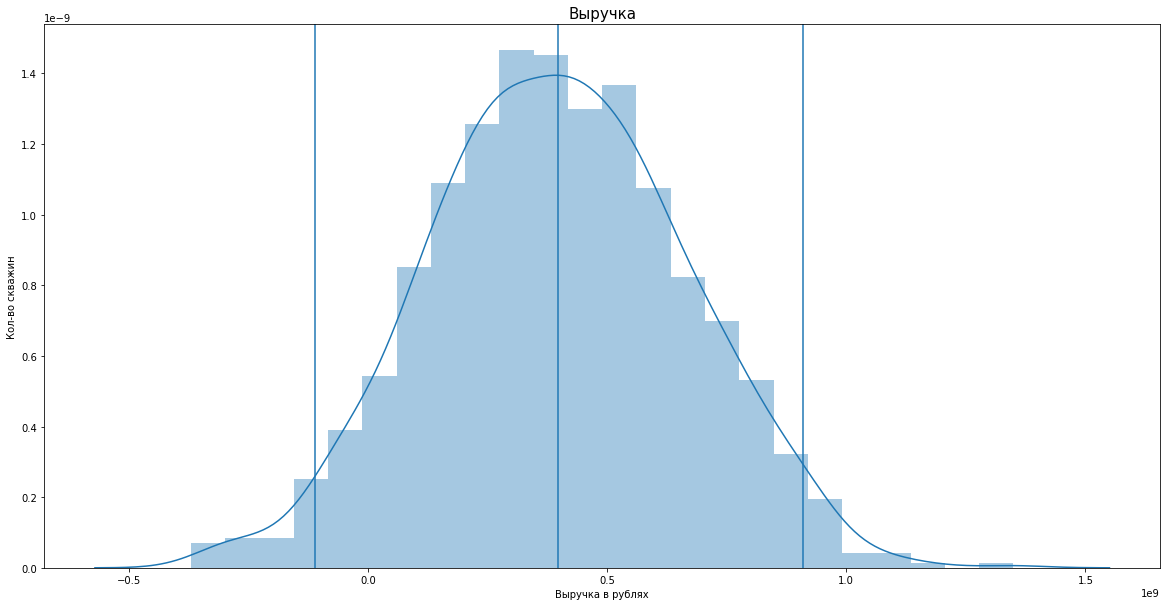

In [37]:
print('Регион 0')
rev_stat(targets_valid[0], predictions[0])

Регион 1
Средняя выручка:459694156.33
95% доверительный интервал: 78050810.75 - 862952060.26
Риск убытков: 0.70%




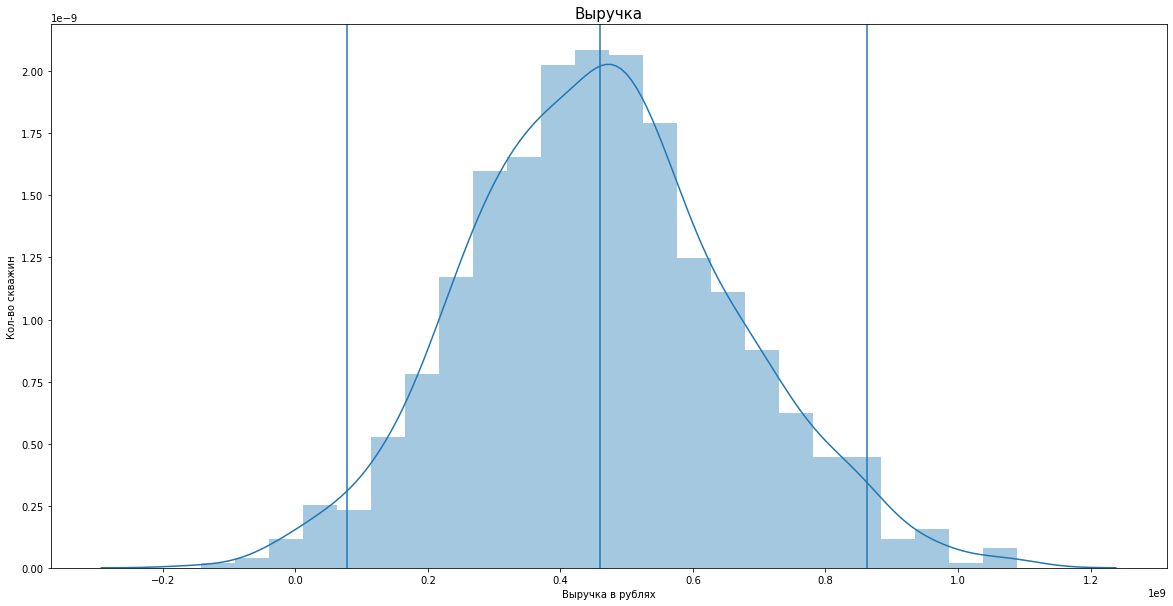

In [38]:
print('Регион 1')
rev_stat(targets_valid[1], predictions[1])

Регион 2
Средняя выручка:391555623.03
95% доверительный интервал: -112227625.38 - 934562914.55
Риск убытков: 6.50%




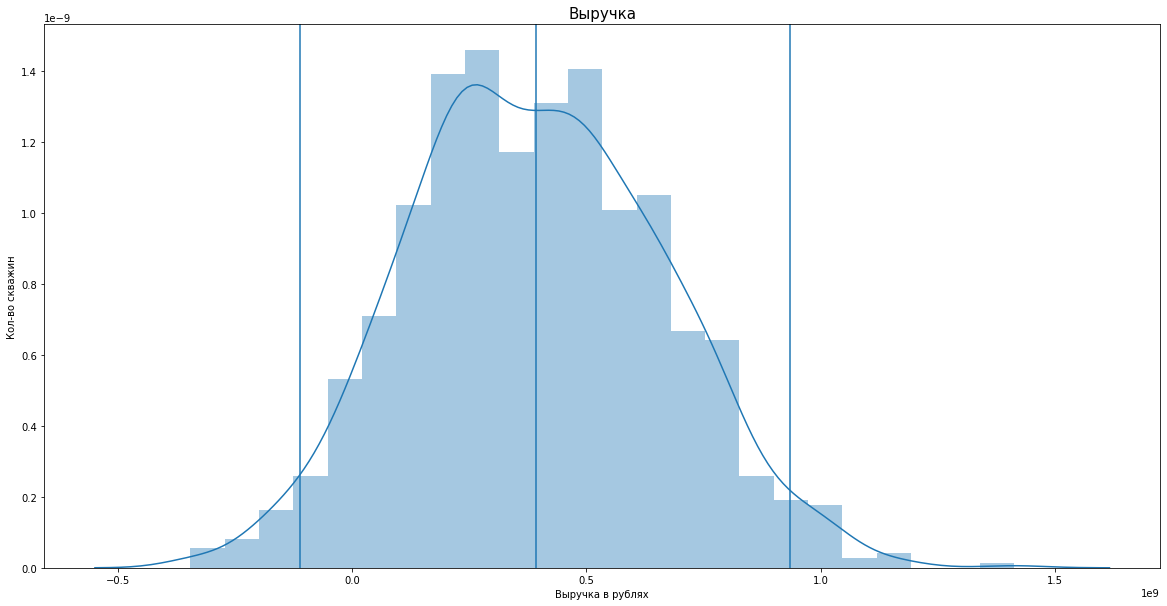

In [39]:
print('Регион 2')
rev_stat(targets_valid[2], predictions[2])

### Общий вывод
Условиям заказчика отвечает только регион под номером 1.

- риск убытков 0.7%
- средняя предполагаемая выручка составляет 459694156.33+е9 рублей (чуть меньше полутриллиона рублей)
- в этом регионе эффективная модель предсказания (RMSE = 0.89)

Данные с других регионов не позволили построить нам надежные модели. Тем не менее риск убытков по не самым надежным моделям превышает условия заказчика.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован